## True Solution
The solution of the function for Gauss Newton, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$ natural gradient descent is:
$$u(x, y) = sin(\pi x)sin(\pi y) + sin(3\pi x)sin(3\pi y)$$
For Fisher-Rao and $W_1$ natural gradient descent, the truth function is:
$$u(x, y) = sin(\pi x)sin(\pi y) + sin(3\pi x)sin(3\pi y)+ 3$$

## Poisson Equation 
All 7 algorithms have the same 2D Poisson equation and the same RHS function f:
$$u_{xx} + u_{yy} = f = -2\pi^2sin(\pi x)sin(\pi y) - 18\pi^2 sin(3\pi x)sin(3\pi y)$$

## Data and Discretization
The data frame we use is a square: $[-1, 1] \times [-1, 1]$. We evenly discretize this frame into 50 by 50 data points. We have 196 boundary points and 2304 colocation points. The plot of the data points are shown below.

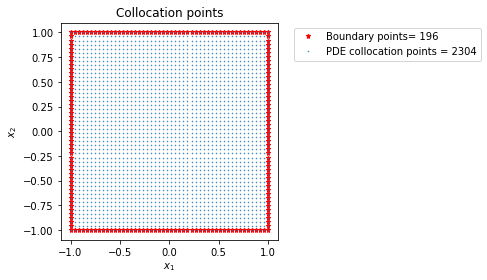

In [2]:
from PINN2D_tool import *
X_f_train, X_u_train, u_train = gridData(50)
plotData(X_f_train, X_u_train)

## PINN Architecture
We used PINN of shape (2, 20, 30, 20, 1). The activation functions are all tanh function. 

### Parameter Initialization
The weights of the PINN are initialized using Gaussian distributions. For weights $w$ between two layers, in which input dimension is $d_1$ and output dimension is $d_2$, $w$ satisfies:
$$w \sim N(0, \frac{2}{d_1 + d_2})$$

For Gauss Newton, $H^1$, $H^{-1}$, $\dot{H}^1$, $\dot{H}^{-1}$ natural gradient descent, the biases are all initialized to be 0. For Fisher-Rao and $w_2$ natural gradient descent, all biases are initialized to bw zero, except the biases in the last layer, which are inialized to be 3. 

We use a random seed to generate these weights parameters. Fixing the random seed, the initial parameter of the PINN are identity for all algorithms and experiments. But note that the biases in the last layer for Fisher-Rao and $W_2$ natural gradient descent are different from other algoroithms. 

## Hyperparameters
#### Weight $\gamma$ in loss function
The loss function is created by a linear combination of the loss of colocation points and boundary points. Suppose the colocation loss is $loss_{f}$ and the boundary points loss is $loss_u$, the total loss is:
$$loss = \gamma  loss_u + (2-\gamma)  loss_f$$
Since there is a magnitude separation between the boundary loss and the colocation loss, we use $\gamma = 1.99$ to add more weights on the boundary points to impose the boudnary condition.

#### Number of iterations
We did 2000 iterations for all 7 algorithms.

#### Damping factor
We used damping factor $\alpha=0$ for all natural gradient descent algorithms.

#### Random Seed
We use random seed 0 to generate the initial parameters.